In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import dc_stat_think as dcst # import dc_stat_think package from Datacamp for bootstrap and ecdf calculation

In [2]:
#Import CARB GTI 2018 study on residential meter sets, 
#The csv file only includes measurements where bubbles were seen (data where bubbles were not observed are excluded)
carb = pd.read_csv('CARB_res_meter_set.csv') 

#Import GTI soap test experiment data (roughly 100+ data points)
gti = pd.read_csv('Soap_test_experiments_results.csv')

#Import DOE industrial meter set data

In [3]:
#Add a column in CARB dataset to convert average flow rate from SCFM to SCFH
carb['leak_rate_scfh'] = carb['LEAK.RATE.AVE.SCFM'] * 60

In [4]:
#Selecting only important columns. Repeat measurements, bushing_id, union_id columns are dropped
carb = carb[['DAE.ID', 'COMPANY', 'SITE.ID', 'BUBBLE.SEEN', 'leak_rate_scfh', 'TOOL.USED', 'LEAKING.COMPONENT']]

carb['source'] = 'CARB study'

#Drop rows with missing average leak rate data
carb.dropna(subset=['leak_rate_scfh'], inplace=True, axis='rows')
carb.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source
0,14,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study
2,23,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study
3,27,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study
4,43,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study
7,70,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study


In [5]:
#Rename leak rate columns so it has the same name as the carb data
gti.rename(columns ={'Leak_size_scfh' : 'leak_rate_scfh'}, inplace=True)
gti['source']='GTI lab'
gti.head()

,Experiment_ID,Thread_type,Soap_solution,leak_rate_scfh,Largest_bubble_size_in,Leak_grade,source
0,1,Bare,Mega,0.003,0.0,3.0,GTI lab
1,2,Bare,Mega,0.004,0.0,3.0,GTI lab
2,3,Bare,Mega,0.006,0.0,3.0,GTI lab
3,4,Bare,Mega,0.009,0.1,3.0,GTI lab
4,5,Bare,Mega,0.010,0.1,3.0,GTI lab


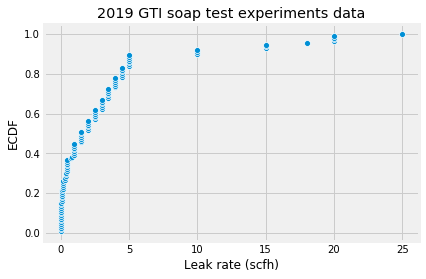

In [6]:
#Plot the cumulative distribution curve of the GTI experimental data (112 data points)
gti_flow_rate, gti_ecdf = dcst.ecdf(gti.leak_rate_scfh)
_ = sns.scatterplot(x=gti_flow_rate, y=gti_ecdf)
_ = plt.title('2019 GTI soap test experiments data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
plt.show()

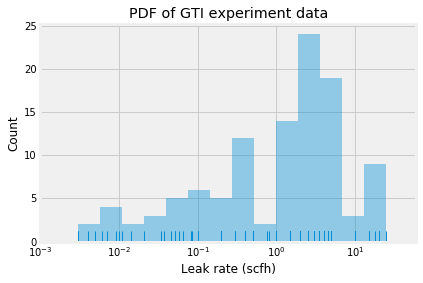

In [7]:
#Plot the pdf of the GTI experiment data

#Plot the pdf of the dataset
LogMin, LogMax = np.log10(gti_flow_rate.min()),np.log10(gti_flow_rate.max())
newBins = np.logspace(LogMin, LogMax, 15)

ax = sns.distplot(gti_flow_rate, kde=False, bins = newBins, rug=True)
ax.set(xscale="log")
_ = plt.title('PDF of GTI experiment data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('Count')
_ = plt.xlim(0.001, 60)

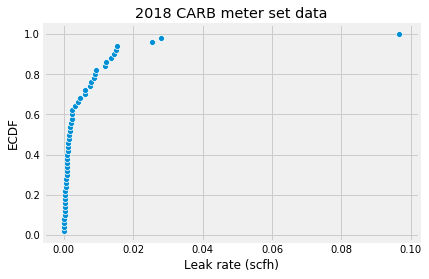

In [8]:
#Plot the cumulative distribution curve of the GTI experimental data (50 data points)
carb_flow_rate, carb_ecdf = dcst.ecdf(carb.leak_rate_scfh)
_ = sns.scatterplot(x=carb_flow_rate, y=carb_ecdf)
_ = plt.title('2018 CARB meter set data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
plt.show()

In [9]:
#Combine the carb and gti datasets 
#Including all the thread types and soap solutions from GTI data
combined = pd.merge(carb, gti,how='outer')

In [10]:
combined.shape

(162, 13)

In [11]:
combined.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source,Experiment_ID,Thread_type,Soap_solution,Largest_bubble_size_in,Leak_grade
0,14.0,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study,NaN,NaN,NaN,NaN,NaN
1,23.0,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study,NaN,NaN,NaN,NaN,NaN
2,27.0,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study,NaN,NaN,NaN,NaN,NaN
3,43.0,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study,NaN,NaN,NaN,NaN,NaN
4,70.0,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study,NaN,NaN,NaN,NaN,NaN


In [12]:
#Drop every other column except leak_rate_scfh to simplify analysis
combined = combined[['leak_rate_scfh', 'source']]
combined.sort_values(by = ['leak_rate_scfh'], ascending = True, inplace=True)
combined.head()

,leak_rate_scfh,source
25,0.000001,CARB study
10,0.000085,CARB study
32,0.000124,CARB study
1,0.000140,CARB study
30,0.000234,CARB study


In [13]:
#Bins for partitioning the data based on observations of GTI experimental data, 4 categories
ground = 0
max_c = 0.014
max_b = 4  # previously 2
max_a = 25 # previously 25

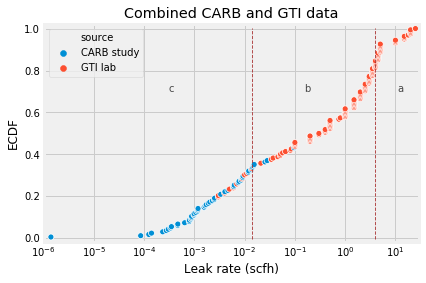

In [14]:
#Plot the ECDF of the combined dataset
combined_flow_rate, combined_ecdf =dcst.ecdf(combined.leak_rate_scfh)
combined['ecdf'] = combined_ecdf
_ = sns.scatterplot(x='leak_rate_scfh', y='ecdf', hue = 'source', data=combined)
_ = _.set(xscale="log")
_ = plt.xlim(0.000001, 30)
_ = plt.title('Combined CARB and GTI data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 0.7, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.15, y= 0.7, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 0.7, s='a', color='black', alpha =0.7)

plt.show()

#There is an outlier on the left side around 1.4E-6 in size from the CARB study
#The largest leak found during the CARB study was 0.097 scfh
#The maximum size tested at GTI is 25 scfh

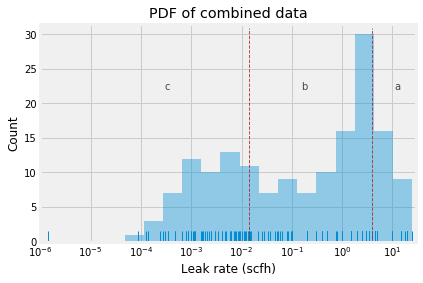

In [15]:
#Plot the pdf of the dataset
LogMin, LogMax = np.log10(combined.leak_rate_scfh.min()),np.log10(combined.leak_rate_scfh.max())
newBins = np.logspace(LogMin, LogMax, 20)

ax = sns.distplot(combined.leak_rate_scfh, kde=False, bins = newBins, rug=True)
ax.set(xscale="log")
_ = plt.title('PDF of combined data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('Count')
_ = plt.xlim(0.000001, 30)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 22, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.15, y= 22, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 22, s='a', color='black', alpha =0.7)

plt.show()

In [16]:
grp_c = combined[combined.leak_rate_scfh <= max_c]['leak_rate_scfh']
grp_b = combined[(combined.leak_rate_scfh > max_c) & (combined.leak_rate_scfh <= max_b)]['leak_rate_scfh']
grp_a = combined[(combined.leak_rate_scfh > max_b)]['leak_rate_scfh']

print("the total number of data points should be 162: ", (grp_c.shape[0] + grp_b.shape[0] + 
                                                          grp_a.shape[0]))

#if the total is 162, it means that we are not losing any data

the total number of data points should be 162:  162


In [17]:
d = {   'c':grp_c.shape[0],
        'b':grp_b.shape[0],
        'a':grp_a.shape[0]}

#Create a table with the number of data points for each category
tally = pd.DataFrame(list(d.items()), columns =['category', 'number_of_points'])

In [18]:
mean_c = round(np.mean(grp_c), 4)
mean_b = round(np.mean(grp_b), 4)
mean_a = round(np.mean(grp_a), 4)

median_c = round(np.median(grp_c), 4)
median_b = round(np.median(grp_b), 4)
median_a = round(np.median(grp_a), 4)

tally['mean_rate_scfh'] = [mean_c, mean_b, mean_a]
tally['median_rate_scfh'] = [median_c, median_b, median_a]
tally['decription'] = ['Soap solution creates foam with little to no visible bubbles',
                       'Soap solution can hold a cluster of bubbles (small to medium), including small bubbles', 
                       'Soap solution is blown off']
tally

,category,number_of_points,mean_rate_scfh,median_rate_scfh,decription
0,c,54,0.0038,0.002,Soap solution creates foam with little to no v...
1,b,83,1.4033,1.000,Soap solution can hold a cluster of bubbles (s...
2,a,25,10.4000,5.000,Soap solution is blown off


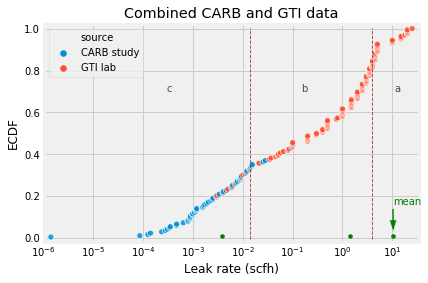

In [19]:
#Plot the ECDF of the combined dataset
_ = sns.scatterplot(x='leak_rate_scfh', y='ecdf', hue ='source', data=combined, alpha =0.85)
_ = _.set(xscale="log")
_ = plt.xlim(0.000001, 35)
_ = plt.title('Combined CARB and GTI data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 0.7, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.15, y= 0.7, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 0.7, s='a', color='black', alpha =0.7)

#Add green dots in each group to show where the mean is
_= plt.plot(mean_c, 0.01, color = 'green', marker ='.', markersize = 7)
_= plt.plot(mean_b, 0.01, color = 'green', marker ='.', markersize = 7)
_= plt.plot(mean_a, 0.01, color = 'green', marker ='.', markersize = 7)

_= plt.annotate('mean', 
                xy=(mean_a, 0.03), 
                xytext =(mean_a - 0.1, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

In [20]:
#Create the x values and ecdf to plot the ecdf of each 
c_flow, c_ecdf =dcst.ecdf(grp_c)
b_flow, b_ecdf =dcst.ecdf(grp_b)
a_flow, a_ecdf =dcst.ecdf(grp_a)

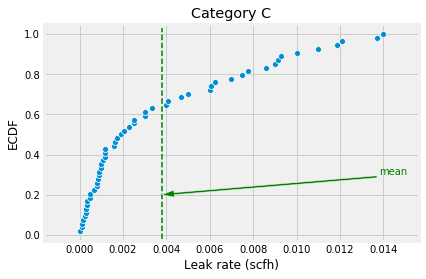

In [21]:
_ = sns.scatterplot(x=c_flow, y=c_ecdf)
_ = plt.title('Category C')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_c, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_c, 0.2), 
                xytext =(mean_c + 0.01, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

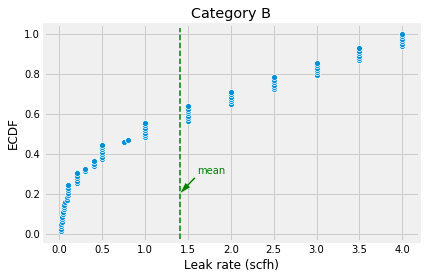

In [22]:
_ = sns.scatterplot(x=b_flow, y=b_ecdf)
_ = plt.title('Category B')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_b, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_b, 0.2), 
                xytext =(mean_b + 0.2, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

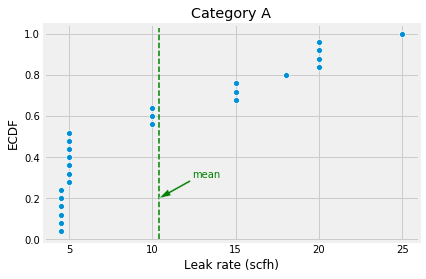

In [23]:
_ = sns.scatterplot(x=a_flow, y=a_ecdf)
_ = plt.title('Category A')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_a, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_a, 0.2), 
                xytext =(mean_a + 2, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

In [24]:
#Part 2#
# Simulate a non-normal distribution to fit the CARB data
carb.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source
0,14,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study
2,23,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study
3,27,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study
4,43,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study
7,70,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study


In [25]:
#original leak grade counts for 2018 PG&E MSA leak data
na = 146825
gr_3 = 33201
gr_2 = 2569
gr_1 = 2255

#pre-repair leak grade counts
#na = 146825 + 2967  #include "not available as N/A"
#gr_3 = 29342
#gr_0 = 1004
#gr_2 = 2492 + 1  #include grade 2+
#gr_1 = 2225

#Need to identify the proportion of leaks at PG&E that are grade 3 and 0 as a fraction of total leaks
di = {'N/A': na,
        3: gr_3,
        2: gr_2,
        1: gr_1,
       'Total': na + gr_1 + gr_2 + gr_3
      }

pge_msa = pd.DataFrame(list(di.items()), columns =['Original Leak Grade', 'count'])
pre_total = gr_3 + gr_1 + gr_2
pge_msa['Fraction'] = ['NaN', 
                        round(gr_3 /pre_total, 3),
                        round(gr_2 /pre_total, 3),
                        round(gr_1 /pre_total, 3),
                        (gr_1 + gr_2 + gr_3) /pre_total]

#Fraction of PG&E MSA that has leak grade 0 and 3 out of all leaks
pge_msa.set_index('Original Leak Grade')

,count,Fraction
Original Leak Grade,,
N/A,146825,NaN
3,33201,0.873
2,2569,0.068
1,2255,0.059
Total,184850,1


In [26]:
small_leak_fraction = gr_3/pre_total
print("Fraction of MSA leaks that are grade 0 and 3:", round((small_leak_fraction),3))

Fraction of MSA leaks that are grade 0 and 3: 0.873


In [186]:
# the lognormal function in numpy takes in two key parameters, mean (mu) and stdev (sigma)
#Need to tweak this to get a curve that fits GTI CARB data
# mu = 0.002, sigma =2.2, size = 2000)

mu, sigma = 0.001, 2.6   # previously mu = 0.001, sigma = 2.5

np.random.seed(57) # same random seed as 4 classifications

lognormal = np.random.lognormal(mu, sigma, size = 2500)

x, y =dcst.ecdf(lognormal)
#skew the x data so it starts from very small values
skew_x = x/200
print(skew_x.max())
print(skew_x.min())

36.49444579112127
9.207844718928632e-07


In [187]:
#create a dataframe for simulated distribution for easier processing
sim= pd.DataFrame(skew_x, columns=['leak_rate_scfh'])

#create arrays of data for each leak category
grp_c_sim = sim[(sim.leak_rate_scfh <= max_c)]['leak_rate_scfh']
grp_b_sim = sim[(sim.leak_rate_scfh > max_c) & (sim.leak_rate_scfh <= max_b)]['leak_rate_scfh']
grp_a_sim = sim[(sim.leak_rate_scfh > max_b)]['leak_rate_scfh']

In [188]:
d_sim = {'c':grp_c_sim.shape[0],
        'b':grp_b_sim.shape[0],
        'a':grp_a_sim.shape[0]}

#Create a table with the number of data points for each category
tally_sim = pd.DataFrame(list(d_sim.items()), columns =['category', 'number_of_points'])

In [189]:
mean_c = round(np.mean(grp_c_sim), 4)
mean_b = round(np.mean(grp_b_sim), 4)
mean_a = round(np.mean(grp_a_sim), 4)

median_c = round(np.median(grp_c_sim), 4)
median_b = round(np.median(grp_b_sim), 4)
median_a = round(np.median(grp_a_sim), 4)

tally_sim['simulated_fraction'] = tally_sim['number_of_points']/tally_sim.number_of_points.sum()
tally_sim['mean_rate_scfh'] = [mean_c, mean_b, mean_a]
tally_sim['median_rate_scfh'] = [median_c, median_b, median_a]
tally_sim['description'] = ['Foam with little to no bubbles',
                       'A cluster of small to medium bubbles', 
                       'Soap solution is blown off']
tally_sim['msa_leak_fraction'] = np.divide([gr_3, gr_2, gr_1], pre_total)
tally_sim['msa_leak_fraction'] = round(tally_sim['msa_leak_fraction'], 4)

tally_sim = tally_sim[['category', 'description', 'number_of_points', 'mean_rate_scfh', 'median_rate_scfh', 'simulated_fraction', 'msa_leak_fraction']]

In [192]:
pre_total

38025

In [193]:
tally_sim

,category,description,number_of_points,mean_rate_scfh,median_rate_scfh,simulated_fraction,msa_leak_fraction
0,c,Foam with little to no bubbles,1665,0.0032,0.0016,0.6660,0.8731
1,b,A cluster of small to medium bubbles,818,0.2309,0.0637,0.3272,0.0676
2,a,Soap solution is blown off,17,9.4972,7.3371,0.0068,0.0593


In [194]:
#Shrink CARB data so the ECDF is capped at the fraction of leaks that are in grade 0 and 3. 
# We do this because CARB data has small leaks with the largest one being 0.1 scfh so it represents leaks in
# the small categories
capped_carb_ecdf = carb_ecdf*small_leak_fraction

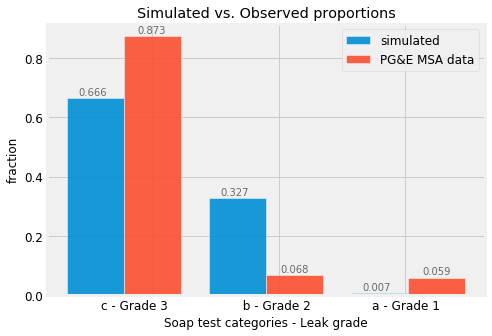

In [195]:
#Plot pdf of simulated distribution versus PG&E data
# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = list(tally_sim.simulated_fraction)
bars2 = list(tally_sim.msa_leak_fraction)
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(7,5))
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='simulated', alpha=0.9)
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='PG&E MSA data', alpha=0.9)
 
# Add xticks on the middle of the group bars
plt.xlabel('Soap test categories - Leak grade', fontsize='large')
plt.xticks([r*0.89 + barWidth for r in range(len(bars1))], ['c - Grade 3         ', '  b - Grade 2   ', 'a - Grade 1'])
plt.ylabel('fraction', fontsize='large')
plt.title('Simulated vs. Observed proportions')

#add labels above each bar
for i, v in enumerate(bars1):
    plt.text(i-0.12, v+0.01, str(round(v,3)), color='dimgray', fontsize='medium')
    
for i, v in enumerate(bars2):
    plt.text(i+0.3, v+0.01, str(round(v,3)), color='dimgray', fontsize='medium')
    
# Create legend & Show graphic
plt.legend(fontsize='large')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()


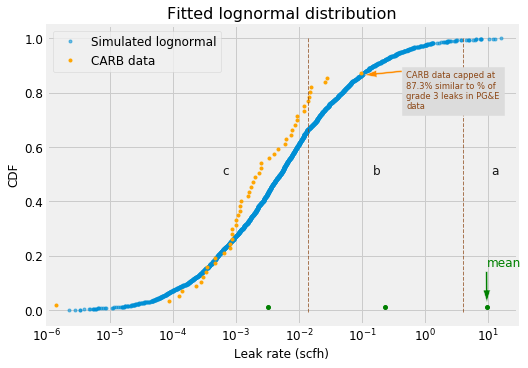

In [196]:
_=plt.figure(figsize=(7.5,5.5))
_=plt.semilogx(skew_x, y, marker ='.', linestyle='none', alpha=0.55)
_=plt.semilogx(carb_flow_rate, capped_carb_ecdf, marker='.', linestyle='none', color='orange')
_=plt.xlim(0.000001, 28)
_=plt.legend(['Simulated lognormal', 'CARB data'], loc ='upper left', fontsize = 'large')
_=plt.xlabel('Leak rate (scfh)')
_=plt.ylabel('CDF')
_=plt.title('Fitted lognormal distribution', fontsize=16)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_c, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)
_ = plt.axvline(max_b, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0006, y= 0.5, s='c', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=0.15, y= 0.5, s='b', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=11, y= 0.5, s='a', color='black', alpha =0.9, fontsize=12)

#Add green dots in each group to show where the mean is
_= plt.plot(mean_c, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_b, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_a, 0.01, color = 'green', marker ='.', markersize = 8)

_= plt.annotate('mean', 
                xy=(mean_a, 0.03), 
                xytext =(mean_a - 0.1, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green',
                fontsize =12)

_= plt.annotate('CARB data capped at\n87.3% similar to % of\ngrade 3 leaks in PG&E\ndata', 
                xy=(0.11, 0.865), 
                xytext =(0.5, 0.74),
                arrowprops = {'facecolor': 'darkorange', 'headwidth': 7, 'width': 2}, 
                color='saddlebrown', fontsize='small', alpha = 0.99, backgroundcolor= 'gainsboro')


plt.xticks(size=12)
plt.yticks(size=12)
plt.show()